In [33]:
import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import test_systems_1d as systems_1d
import itertools
from tqdm import tqdm
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import Normalize

Training data

In [21]:
# Display?
display_subset = False
how_many = 5
####################

# Parameters
n_features = 1000
n_targets = n_features

n_samples_V_train = 100
n_samples_H_0_train = 100
v_range_train = (1, 10)
H_0_range_train = (1, 10)

x_range = (-30, 30)
####################

x = np.linspace(x_range[0], x_range[1], n_features)

rng = np.random.default_rng(seed=99)
V_arr_train = np.random.uniform(v_range_train[0], v_range_train[1], n_samples_V_train)
H_0_arr_train = np.random.uniform(H_0_range_train[0], H_0_range_train[1], n_samples_H_0_train)

train_params = np.array(list(itertools.product(V_arr_train, H_0_arr_train)))
n_samples_train = train_params.shape[0]

x_train = np.zeros((n_samples_train, n_features))
y_train = np.zeros((n_samples_train, n_targets))

for i, params in enumerate(train_params):
    x_train[i, :] = systems_1d.diffusion(x = x, t = 0, D = 1, V = train_params[i, 0], H_0 = train_params[i, 1])
    y_train[i, :] = systems_1d.diffusion(x = x, t = 5, D = 1, V = train_params[i, 0], H_0 = train_params[i, 1])

    if (i+1) % int(n_samples_train/how_many) == 0 and display_subset:
        print(f'{i+1}/{n_samples_train}: V = {params[0]}, H_0 = {params[1]}')
        plt.figure()
        plt.plot(x, x_train[i, :], label='x_train')
        plt.plot(x, y_train[i, :], label='y_train')
        plt.legend()
        plt.show()

In [22]:
regressor_list = [LinearRegression() for i in range(n_targets)]

for i in tqdm(range(n_targets)):
    regressor_list[i].fit(x_train, y_train[:, i])

100%|██████████| 1000/1000 [07:12<00:00,  2.31it/s]


Testing

In [40]:
n_samples_V_test = 40
n_samples_H_0_test = 40

rng = np.random.default_rng(seed=98)
V_arr_test = np.linspace(1, 40, n_samples_V_test)
H_0_arr_test = np.linspace(1, 40, n_samples_H_0_test)

test_params = np.array(list(itertools.product(V_arr_test, H_0_arr_test)))
n_samples_test = test_params.shape[0]
test_params_arr = test_params.reshape((n_samples_V_test, n_samples_H_0_test, 2))

x_test = np.zeros((n_samples_test, n_features))
y_test = np.zeros((n_samples_test, n_targets))

for i, params in enumerate(test_params):
    x_test[i, :] = systems_1d.diffusion(x = x, t = 0, D = 1, V = test_params[i, 0], H_0 = test_params[i, 1])
    y_test[i, :] = systems_1d.diffusion(x = x, t = 5, D = 1, V = test_params[i, 0], H_0 = test_params[i, 1])

100%|██████████| 1000/1000 [00:01<00:00, 735.77it/s]
/var/folders/pq/m1s3wh755x9fhcy2gq520_3r0000gn/T/ipykernel_64742/1972456278.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  worst_index_rmse = int(np.where(rmse == np.max(rmse))[0])
/var/folders/pq/m1s3wh755x9fhcy2gq520_3r0000gn/T/ipykernel_64742/1972456278.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_index_rmse = int(np.where(rmse == np.min(rmse))[0])


(1600, 1000)
(1600, 1000)
(1600,)
(1600,)
index 1560 was the worst result with an RMSE of 926702.3366618706 for V=40.0 and H_0=1.0


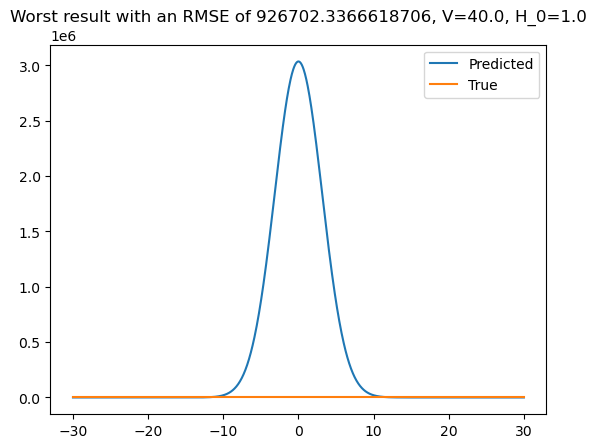

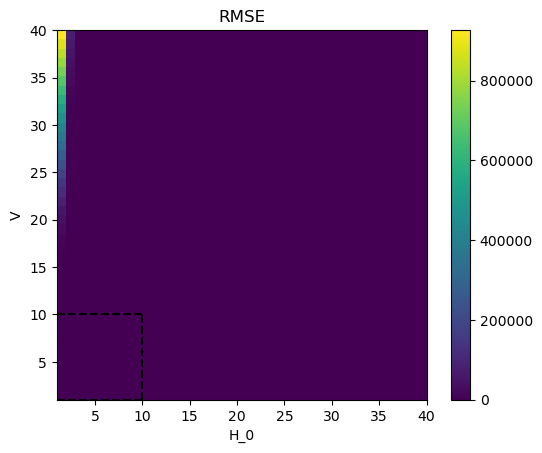

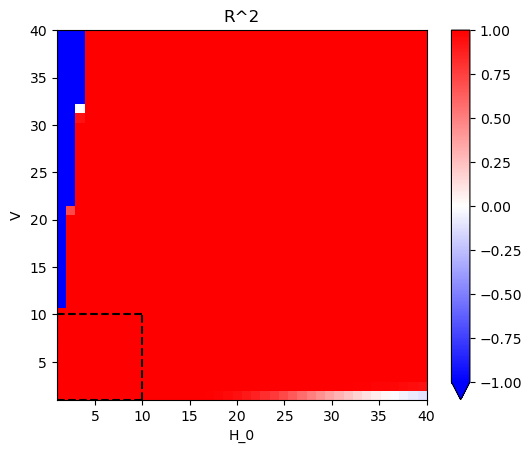

In [43]:
def plot_box(x_coords, y_coords):
    plt.vlines(x_coords[0], y_coords[0], y_coords[1], color='black', linestyle='--')
    plt.vlines(x_coords[1], y_coords[0], y_coords[1], color='black', linestyle='--')
    plt.hlines(y_coords[0], x_coords[0], x_coords[1], color='black', linestyle='--')
    plt.hlines(y_coords[1], x_coords[0], x_coords[1], color='black', linestyle='--')

y_test_pred = np.zeros((n_samples_test, n_targets))

for i in tqdm(range(n_targets)):
    y_test_pred[:, i] = regressor_list[i].predict(x_test)

print(y_test_pred.shape)
print(y_test.shape)

rmse = np.sqrt(mean_squared_error(y_test.T, y_test_pred.T, multioutput='raw_values'))
r2 = r2_score(y_test.T, y_test_pred.T, multioutput='raw_values')

print(rmse.shape)
print(r2.shape)

worst_index_rmse = int(np.where(rmse == np.max(rmse))[0])
best_index_rmse = int(np.where(rmse == np.min(rmse))[0])
print(f'index {worst_index_rmse} was the worst result with an RMSE of {rmse[worst_index_rmse]} for V={test_params[worst_index_rmse, 0]} and H_0={test_params[worst_index_rmse, 1]}')

plt.figure()
plt.plot(x, y_test_pred[worst_index_rmse, :], label='Predicted')
plt.plot(x, y_test[worst_index_rmse, :], label='True')
plt.legend()
plt.title(f'Worst result with an RMSE of {rmse[worst_index_rmse]}, V={test_params[worst_index_rmse, 0]}, H_0={test_params[worst_index_rmse, 1]}')
plt.show()

rmse_arr = rmse.reshape((n_samples_V_test, n_samples_H_0_test))

plt.figure()
norm = Normalize(vmin=0, clip=True)
plt.imshow(rmse_arr[:, :], origin='lower', extent=[H_0_arr_test[0], H_0_arr_test[-1], V_arr_test[0], V_arr_test[-1]], cmap='viridis', norm=norm)
plt.colorbar()
plot_box(H_0_range_train, v_range_train)
plt.xlabel('H_0')
plt.ylabel('V')
plt.title('RMSE')
plt.show()

r2_arr = r2.reshape((n_samples_V_test, n_samples_H_0_test))

plt.figure()
divnorm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
plt.imshow(r2_arr[:, :], origin='lower', extent=[H_0_arr_test[0], H_0_arr_test[-1], V_arr_test[0], V_arr_test[-1]], cmap='bwr', norm=divnorm)
plt.colorbar(extend='min')
plot_box(H_0_range_train, v_range_train)
plt.xlabel('H_0')
plt.ylabel('V')
plt.title('R^2')
plt.show()